In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import env
import numpy as np
import pickle
from bm.utils.dataset import *
from bm.utils.plot_utils import *
from rbm_utils.stutils import *
from rbm_utils.fimdiag import * # functions to compute the diagonal of the FIM for RBMs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec

np.random.seed(42)

GATHER = [
    '#eb7a59', # "Rust"
    '#eea300', # "Ochre"
    '#F0E442', # "Yellow"
    '#5aa0df', # "Azure"
    '#00bac9', # "Turquoise"
    '#CC79A7', # "Violet"
    '#44525c', # "Black"
    '#f1f0e9'] # "White"
RUST,OCHRE,YELLOW,AZURE,TURQUOISE,VIOLET,BLACK, WHITE = GATHER
my_colors = GATHER
fs=16
plt.rcParams.update({'font.size': fs})

### Load CIFAR-10 

In [2]:
radius = 2.1
n_train = 90000
try:
    data = load_cifar_circles(os.path.join('..', 'data', 'cifar-10-batches-py/'), radius)
    X_train = data[np.random.permutation(data.shape[0])[:n_train],:]
except(FileNotFoundError, IOError):
    print("Cannot find CIFAR image data, please run data/fetch_cifar10.sh first")

data_batch_1
data_batch_2
data_batch_5
test_batch
data_batch_4
number of pixels: 13
('data size:', (1800000, 13))


## Initial RBM
### Load results of initial unpruned RBM

In [3]:
nv = X_train.shape[1]
nh = 70
session = 0 # before pruning
n_sess= 3 # pruning sessions

res_link = os.path.join('..', 'models', 'CIFAR')
initial_link = os.path.join(res_link,'Initial{}v{}h/results/'.format(nv,nh))
assert os.path.exists(initial_link), "Model does not exist yet. Train initial RBM first by running CIFAR pruning script"

FI_SAVED = True

# load results
infile = open(os.path.join(initial_link,'session{}_untrained_params.pkl'.format(0)),'rb')
initial_untrained_params = pickle.load(infile)
infile.close()
infile = open(os.path.join(initial_link,'session{}_trained_params.pkl'.format(0)),'rb')
initial_trained_params = pickle.load(infile)
infile.close()
# samples always two times (before and after training)
initial_samples_before_train = np.load(os.path.join(initial_link,'session{}_untrained_samples.npy'.format(0)))
initial_samples_after_train = np.load(os.path.join(initial_link,'session{}_trained_samples.npy'.format(0)))
if FI_SAVED:
    initial_fi = np.load(os.path.join(initial_link,'session{}_trained_fi.npy'.format(0)))
    
ref_samples = initial_samples_after_train

ref_s_v = ref_samples[:,:nv]
ref_s_h = ref_samples[:,nv:]

_,c_ref = unique(ref_s_v[:,:], axis=0, return_counts=True)
p_ref = c_ref/np.sum(c_ref)

### K-plot

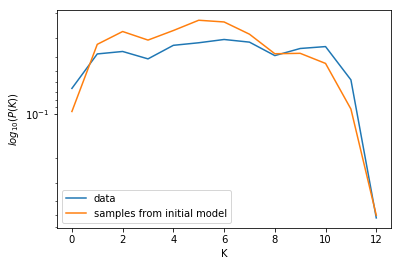

In [4]:
data_spiking_statistic = np.zeros(nv)
for data_bin in X_train:
    number_spiking = np.count_nonzero(data_bin == 1)
    data_spiking_statistic[number_spiking-1] = data_spiking_statistic[number_spiking-1] + 1
data_spiking_statistic = data_spiking_statistic / n_train

sample_spiking_statistic = np.zeros(nv)
for data_bin in ref_s_v:
    number_spiking = np.count_nonzero(data_bin == 1)
    sample_spiking_statistic[number_spiking-1] = sample_spiking_statistic[number_spiking-1] + 1
sample_spiking_statistic = sample_spiking_statistic / n_train

ax = plt.subplot(1,1,1)
plt.plot(range(data_spiking_statistic.shape[0]),  data_spiking_statistic, label='data')
plt.plot(range(sample_spiking_statistic.shape[0]), sample_spiking_statistic, label='samples from initial model')
ax.set_yscale('log')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('K')
plt.ylabel('$log_{10} (P(K))$')
plt.show()

### Rank-frequency plot

In [5]:
_,c_sample = unique(ref_s_v[:,:], axis=0, return_counts=True)
_,c_train = unique(X_train[:,:], axis=0, return_counts=True)

p_sample = c_sample/np.sum(c_sample)
p_train = c_train/np.sum(c_train)

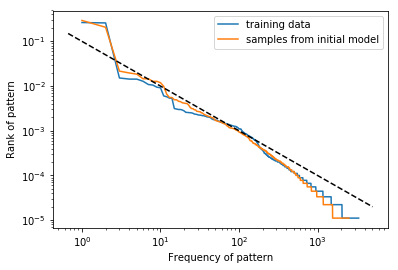

In [6]:
ax = plt.subplot(111)
plt.loglog(np.arange(1,p_train.shape[0]+1),np.sort(p_train)[::-1], label='training data')
plt.loglog(np.arange(1,p_sample.shape[0]+1),np.sort(p_sample)[::-1], label='samples from initial model')
plt.loglog(ax.get_xlim(), .1/np.array(ax.get_xlim()), linestyle='dashed', c='black')
plt.xlabel('Frequency of pattern')
plt.ylabel('Rank of pattern')
plt.legend()

### Fisher Information (FIM, its first eigenvalue and diagonal)


In [7]:
def plot_FI(visbias, hidbias, weights, title=None, vmin=0, vmax=.25, normalize=False, path=None):
    fig = plt.figure(figsize=(7,3))

    if title is not None: 
        fig.suptitle(title,fontsize=fs)
    N_rows_weights, _ = weights.shape
    
    grid=GridSpec(2,3, height_ratios=[1,N_rows_weights], width_ratios=[50,1,1])

    ax_joint = fig.add_subplot(grid[1,0])

    ax_marg_x = fig.add_subplot(grid[0,0], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(grid[1,1], sharey=ax_joint)
    cax = fig.add_subplot(grid[:,2])
    
    # normalize data 
    if normalize: 
        all_data = np.concatenate((visbias.flatten(), hidbias.flatten(), weights.flatten()))
        visbias=(visbias-np.min(all_data))/np.ptp(all_data)
        hidbias=(hidbias-np.min(all_data))/np.ptp(all_data)
        weights=(weights-np.min(all_data))/np.ptp(all_data)
    
    if len(visbias.shape) == 1:
        visbias= visbias[:,np.newaxis]
    if len(hidbias.shape) == 1:
        hidbias= hidbias[np.newaxis,:]
    
    sns.heatmap(visbias, cmap='binary', ax=ax_marg_y, cbar_ax=cax, vmin=vmin, vmax=vmax)
    sns.heatmap(hidbias, cmap="binary", ax=ax_marg_x, cbar_ax=cax,vmin=vmin, vmax=vmax)
    sns.heatmap(weights, cmap="binary", ax=ax_joint, cbar_ax=cax, yticklabels=5, xticklabels=10,vmin=vmin, vmax=vmax)
  
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)  
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)  
    
    text1=ax_joint.set_xlabel("$h_j$")
    ax_joint.set_ylabel("\n$v_i$")
    ax_marg_y.set_xlabel("\nv", fontweight='bold')
    ax_marg_x.set_ylabel("h\n", fontweight='bold')
    
    #plt.tight_layout()
    if path is not None: 
        plt.savefig(path, bbox_inches = "tight")
        
def plot_FIM(fim, normalize=False, vmin=0, vmax=1, path=None):
    fig = plt.figure(figsize=(7,6))
    if normalize: 
        fim = (fim-np.min(fim))/np.ptp(fim)
    plt.imshow(fim, vmin=vmin, vmax=vmax, cmap='binary') 
    plt.ylabel(r'$\phi_i$')
    plt.xlabel(r'$\phi_j$')
    plt.title('FIM', fontsize=fs)
    plt.colorbar()
    plt.tight_layout()
    if path is not None: 
        plt.savefig(path, bbox_inches = "tight")

In [8]:
fim = rbm_fim_numpy(ref_samples.astype(bool), nv) # nv = number of visible units
fim_eigvals, vec = fim_eig(fim, nv, return_eigenvectors=True)
visbias, hidbias, weights = vec
print("Ratio first/second eigenvalue", (fim_eigvals[0]/fim_eigvals[1]))
print(fim_eigvals[0])
print(fim_eigvals[1])
print(fim_eigvals[2])

Ratio first/second eigenvalue 14.96175114837947
23.97343864888457
1.6023150238988684
1.4242530461016512


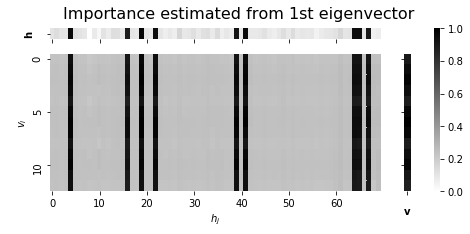

In [9]:
plot_FI(visbias[:,0], hidbias[:,0], weights[:,:,0], vmin=0, vmax=1, normalize=True, title='Importance estimated from 1st eigenvector\n')

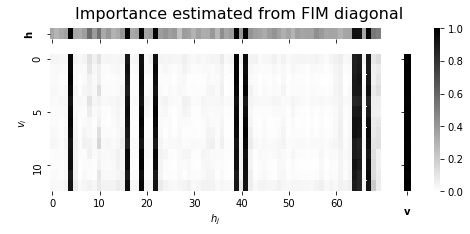

In [10]:
diag = rbm_fim_diag(ref_samples.astype(bool), nv)
plot_FI(diag[:nv], diag[nv:nv+nh], diag[nv+nh:].reshape(nv,nh), vmin=0, vmax=1, normalize=True, title='Importance estimated from FIM diagonal\n')

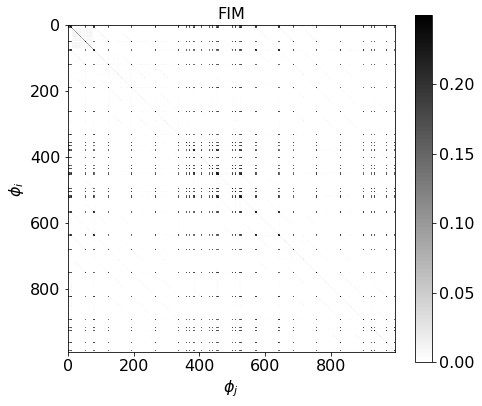

In [34]:
plot_FIM(fim, normalize=False, vmin=0, vmax=fim.max())

## Comparison of RBMs pruned according to different criteria
### Load results of pruned RBMs

In [11]:
my_labels=['Variance FI', 'Heuristic FI', 'First eigenvector', r'$|w|$', 'Random', 'Anti-FI']

exp_names = ['FI_DIAG{}v{}h'.format(nv,nh), 'HEURISTIC_DIAG{}v{}h'.format(nv,nh), 'FIM_EIGENVECTOR{}v{}h'.format(nv,nh),
'WEIGHTMAG{}v{}h'.format(nv,nh), 'RANDOM{}v{}h'.format(nv,nh), 'ANTI{}v{}h'.format(nv,nh)]

untrained_params = [[] for i in exp_names]
retrained_params = [[] for i in exp_names]
untrained_samples = [[] for i in exp_names]
retrained_samples = [[] for i in exp_names]
masks = [[] for i in exp_names]
if FI_SAVED:
    untrained_fi = [[] for i in exp_names]
    retrained_fi = [[] for i in exp_names]

for exp in range(len(exp_names)):
    temp_link = res_link+'/{}/results'.format(exp_names[exp])
    assert os.path.exists(temp_link), f"Model does not exist yet. Run CIFAR pruning script for {my_labels[exp]} pruning"

    for sess in range(1,n_sess+1):
 
        # params always two times (before and after training)
        infile = open(os.path.join(temp_link,'session{}_untrained_params.pkl'.format(sess)),'rb')
        new_dict = pickle.load(infile)
        infile.close()

        untrained_params[exp].append(new_dict)

        infile = open(os.path.join(temp_link,'session{}_trained_params.pkl'.format(sess)),'rb')
        new_dict = pickle.load(infile)
        infile.close()

        retrained_params[exp].append(new_dict)

        # samples always two times (before and after training)
        infile = np.load(os.path.join(temp_link,'session{}_untrained_samples.npy'.format(sess)))
        untrained_samples[exp].append(infile)

        infile = np.load(os.path.join(temp_link,'session{}_trained_samples.npy'.format(sess)))
        retrained_samples[exp].append(infile)

        # masks only one time
        infile = np.load(os.path.join(temp_link,'session{}_untrained_mask.npy'.format(sess)))
        masks[exp].append(infile)

        # FI
        if FI_SAVED:
            infile = np.load(os.path.join(temp_link,'session{}_untrained_fi.npy'.format(sess)))
            untrained_fi[exp].append(infile)

            infile = np.load(os.path.join(temp_link,'session{}_trained_fi.npy'.format(sess)))
            retrained_fi[exp].append(infile)

# training data
_,c_train = unique(X_train[:,:], axis=0, return_counts=True)
p_train = c_train/np.sum(c_train)

### Number of remaining latent units over time

In [12]:
print('Number of latent units')
min_units = len(masks[0][0][0])
for i in range(n_sess):
    print('Pruning session', i+1)
    for j in range(len(exp_names)):
        print(my_labels[j], ': ', len(masks[j][i][0]))
        if len(masks[j][i][0]) < min_units:
            min_units = len(masks[j][i][0])
    print('\n')

Number of latent units
Pruning session 1
Variance FI :  69
Heuristic FI :  61
First eigenvector :  65
$|w|$ :  70
Random :  70
Anti-FI :  57


Pruning session 2
Variance FI :  50
Heuristic FI :  50
First eigenvector :  48
$|w|$ :  62
Random :  68
Anti-FI :  49


Pruning session 3
Variance FI :  9
Heuristic FI :  10
First eigenvector :  9
$|w|$ :  35
Random :  60
Anti-FI :  35




### Rank-frequency plots

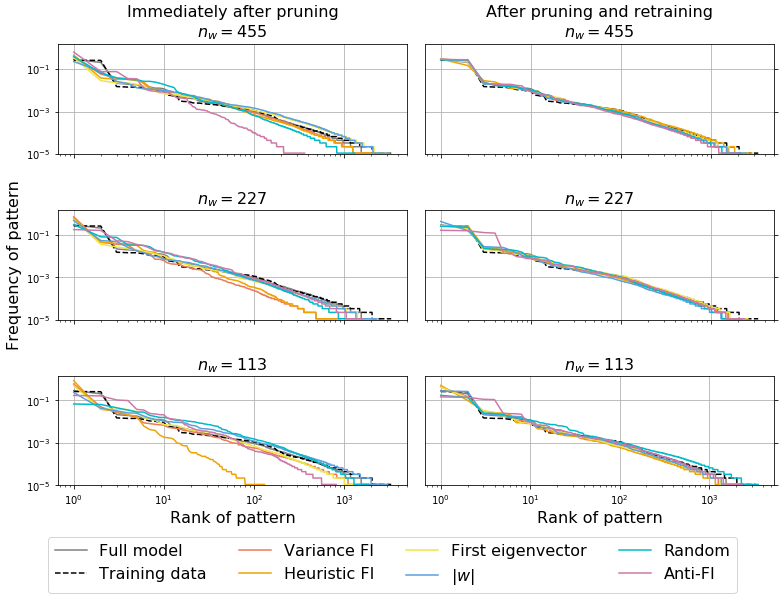

In [13]:
# assert that all models always had the same number of weights when being evaluated
for i in range(len(exp_names)):
    for j in range(n_sess):
        assert np.count_nonzero(np.asarray(masks[0][j])) - np.count_nonzero(np.asarray(masks[i][j])) <= 1 # if uneven numbers (vs anti-FI)

# plot only first pruning, but separate immdiately after pruning and after retraining
fig= plt.figure(figsize=(11,n_sess*2.5))
for i in range(n_sess):
    ax1 = plt.subplot(n_sess,2,i*2+1)
    if i == 0:
        plt.title('Immediately after pruning\n'+r'$n_w = {}$'.format(np.count_nonzero(np.array(masks[exp][i]))), fontsize=fs)
        ax1.loglog(np.arange(1,p_ref.shape[0]+1),np.sort(p_ref)[::-1], c='grey', label='Full model')
        ax1.loglog(np.arange(1,p_train.shape[0]+1),np.sort(p_train)[::-1],  c='black', label='Training data',linestyle='--')
    else:
        plt.title(r'$n_w = {}$'.format(np.count_nonzero(np.array(masks[0][i]))), fontsize=fs)
        ax1.loglog(np.arange(1,p_ref.shape[0]+1),np.sort(p_ref)[::-1], c='grey')
        ax1.loglog(np.arange(1,p_train.shape[0]+1),np.sort(p_train)[::-1],  c='black',linestyle='--')
    if i == n_sess-1:
        ax1.set_xlabel('Rank of pattern', fontsize=fs)
    if i%2:
        ax1.set_ylabel('Frequency of pattern', fontsize=fs)
    for exp in range(len(exp_names)):
        # load untrained_samples
        s = untrained_samples[exp][i]
        s_v = s[:,:nv]
        _,c_model = unique(s_v[:,:], axis=0, return_counts=True)
        p_model = c_model/np.sum(c_model)
        plt.loglog(np.arange(1,p_model.shape[0]+1),np.sort(p_model)[::-1], c=my_colors[exp], label=my_labels[exp])
    ax1.grid()
    if n_sess != 1:
        ax1.set_ylim(10e-6, 1.5)
    if i< n_sess-1:
        ax1.set_xticklabels([])
    if i == 0:
        handles,labels = ax1.get_legend_handles_labels()
        handles = [handles[i] for i in range(len(handles))]
        labels = [labels[i] for i in range(len(labels))]

    ax2 = plt.subplot(n_sess,2,i*2+2)
    if i == 0:
        plt.title('After pruning and retraining\n'+r'$n_w = {}$'.format(np.count_nonzero(np.array(masks[exp][i]))), fontsize=fs)
    else:
        plt.title(r'$n_w = {}$'.format(np.count_nonzero(np.array(masks[0][i]))), fontsize=fs)
    ax2.loglog(np.arange(1,p_ref.shape[0]+1),np.sort(p_ref)[::-1], c='grey')
    ax2.loglog(np.arange(1,p_train.shape[0]+1),np.sort(p_train)[::-1],  c='black', linestyle='--')

    if i == n_sess-1:
        ax2.set_xlabel('Rank of pattern', fontsize=fs)
    #ax2.yaxis.set_label_position("right")
    ax2.set_yticklabels([])
    ax2.yaxis.tick_right()
    ax2.tick_params(labelright=False)
    for exp in range(len(exp_names)):
        # load retrained_samples
        s = retrained_samples[exp][i]
        s_v = s[:,:nv]
        _,c_model = unique(s_v[:,:], axis=0, return_counts=True)
        p_model = c_model/np.sum(c_model)
        plt.loglog(np.arange(1,p_model.shape[0]+1),np.sort(p_model)[::-1], c=my_colors[exp])
        ax2.set_ylim(ax1.get_ylim())
    if i< n_sess-1:
        ax2.set_xticklabels([])
    ax2.grid()

fig.tight_layout()
lgd= fig.legend(handles, labels, ncol=4, loc = 'lower center', bbox_to_anchor = (0,-0.12,1,1),bbox_transform = plt.gcf().transFigure, fontsize=fs)

### Plot receptive fields of latent units ordered by their importance
Color denotes weight magnitude from a latent unit to all visible units

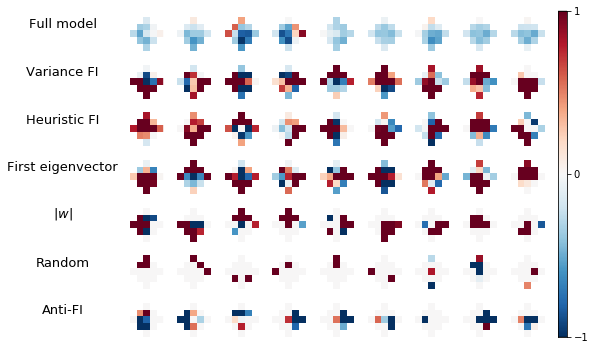

In [14]:
# Plot remaining receptive fields after 3 iterations of pruning
cmap = plt.cm.RdBu_r

initial_weights = initial_trained_params['W']
# receptive fields before Pruning
nv = initial_weights.shape[0]
nh = initial_weights.shape[1]

rfd = int(np.ceil(radius*2))+1
im = np.empty((rfd, rfd), dtype=float)
x, y = np.ogrid[0:rfd, 0:rfd]
x = x - int(rfd/2)
y = y - int(rfd/2)
inds = np.sqrt(1. * x * x + 1. * y * y) <= radius
im[~inds] = np.nan

number_per_line = min_units
all_labels = ['Full model'] + my_labels

# order them by their mean importance
if FI_SAVED: 
    important_hid =[]
    unimportant_hid = []
    initial_fi = initial_fi.reshape(nv,nh)
    initial_mean_fi = np.mean(np.abs(initial_fi), axis=0)
    indices_largest_FI =(-initial_mean_fi).argsort()[:min_units]
    indices_lowest_FI= initial_mean_fi.argsort()[:min_units]

    important_hid.append(indices_largest_FI)
    unimportant_hid.append(indices_lowest_FI)

    for i in range(len(exp_names)):
        curr_mask = masks[i][-1] # take mask of last iteration
        curr_fi = retrained_fi[i][-1].reshape(curr_mask.shape[0], curr_mask.shape[1]) * curr_mask

        mean_fi_per_hid = np.mean(np.abs(curr_fi), axis=0)
        indices_largest_FI= (-mean_fi_per_hid).argsort()[:min_units]
        indices_lowest_FI = mean_fi_per_hid.argsort()[:min_units]

        important_hid.append(indices_largest_FI)
        unimportant_hid.append(indices_lowest_FI)

    fig = plt.figure(figsize=(20, 6))
    grid = ImageGrid(fig, 111 ,         # as in plt.subplot(111)
                     nrows_ncols=(len(exp_names)+1,number_per_line),
                     axes_pad=0.1,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="3%",
                     cbar_pad=0.2,
                     )
    for i in range(len(exp_names)+1):
        if i == 0: # use parameters from initial model
            current_weights = initial_trained_params['W']
        else:
            current_weights = retrained_params[i-1][-1]['W']
        for j in range(number_per_line):
            ordered_hids = important_hid[i]
            ax = grid[i*number_per_line+j]
            im[inds] = current_weights[:,ordered_hids[j]]#.flatten()
            vmin,vmax=-1,1
            image = ax.imshow(im,vmin=vmin,vmax=vmax, cmap=cmap)
            if j == 0:
                ax.spines['bottom'].set_color('white')
                ax.spines['top'].set_color('white')
                ax.spines['left'].set_color('white')
                ax.spines['right'].set_color('white')
                ax.set_ylabel(all_labels[i], rotation=0,labelpad=60, fontsize=13)
                ax.set_yticks(())
                ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)
            else:
                ax.set_xticks(())
                ax.set_yticks(())
                ax.axis('off')
    # Colorbar
    cbarticks = np.arange(-1,1.01,1)
    ax.cax.colorbar(image, ticks=cbarticks)
    ax.cax.toggle_label(True)
    plt.show()